In [1]:
import eikon as ek
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display, HTML
import os
# from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant
import seaborn as sns
from scipy import stats
import time

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [3]:
data_path = r'C:\Users\serge\IdeaProjects\portfolio_manager\data\fama-french-factors'

In [4]:
os.listdir(data_path)

['Developed_3_Factors.csv',
 'Developed_3_Factors_Daily.csv',
 'Developed_5_Factors.csv',
 'Developed_5_Factors_Daily.csv',
 'Developed_MOM_Factor.csv',
 'Developed_MOM_Factor_Daily.csv',
 'Europe_3_Factors.csv',
 'Europe_3_Factors_Daily.csv',
 'rar']

In [5]:
file = 'Developed_5_Factors_Daily.csv'

In [6]:
path_apikeys = r'C:\Users\serge\OneDrive\Documents'
ek_api_key = pd.read_csv(fr'{path_apikeys}\apikeys.csv', names=['api', 'key'], index_col=0)
ek.set_app_key(ek_api_key.loc['reuters'].values[0])

In [7]:
def get_index_constituents(eikon_object, index: str = '.GDAXI'):
    all_rics = []
    t0 = time.time()
    index = list(index)
    for i in range(len(index)):
        try:
            temp_rics, err = ek.get_data(index[i], ['TR.IndexConstituentRIC' , 'TR.IndexConstituentName'], {'SDate':'20230321'})
        # all_rics, err = ek.get_data(indices_rics[2], ['TR.IndexConstituentRIC' , 'TR.IndexConstituentName'])
            print(f'Retrieved {time.time() - t0}')
        except Exception as e:
            print(err)
        if err is None:
            all_rics.append(temp_rics['Constituent RIC'].to_list())
    return all_rics

In [8]:
indices_rics = ['LVMH.PA', 'ASML.AS', 'NESN.S', 'LIN',
                'NOVOb.CO', 'AAPL.O', 'ROG.S', 'UNH',
                'SAPG.DE', 'MSFT.O']
# indices_rics = get_index_constituents(ek, '.GDAXI')
# indices_rics

In [9]:
# end_row = 402
header_row = 2
index_row = 0
df_factors = pd.read_csv(filepath_or_buffer=fr'{data_path}\\{file}',
                           header=header_row,
                           index_col=index_row,
                           parse_dates=True, 
                           usecols=range(7))
#                            nrows=(end_row-8))

df_factors.replace({-99.99:np.nan}, inplace=True)

In [10]:
df_factors.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2023-04-24,0.14,-0.04,0.21,0.18,0.29,0.02
2023-04-25,-1.38,0.00,0.12,0.15,0.61,0.02
2023-04-26,-0.38,0.03,-0.25,0.14,-0.02,0.02
2023-04-27,1.23,-0.62,-0.44,0.23,-0.33,0.02
2023-04-28,0.56,0.01,0.02,0.12,0.09,0.02


In [11]:
df_factors = df_factors / 100

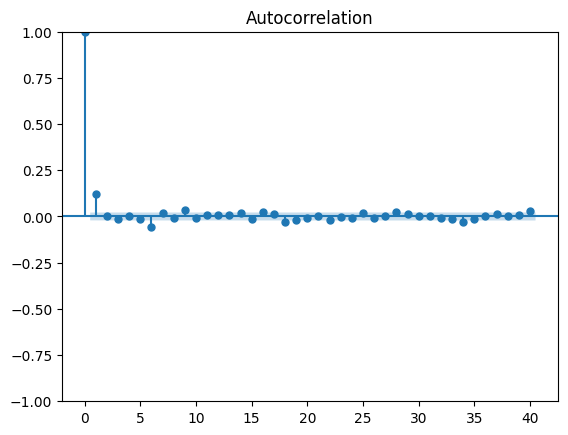

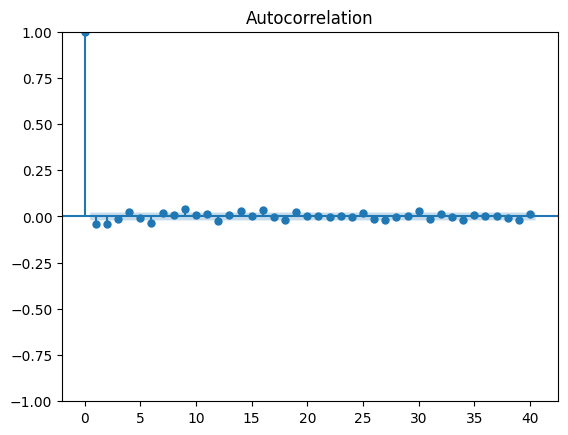

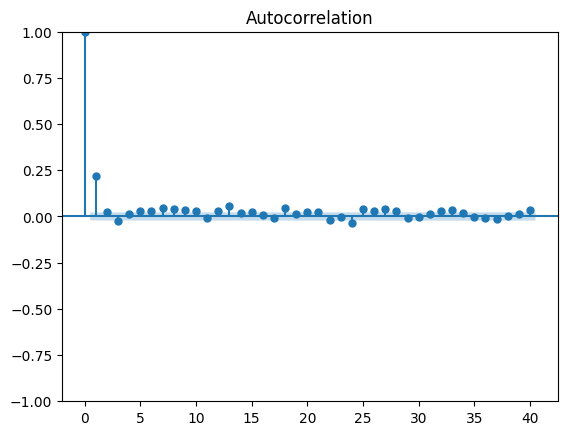

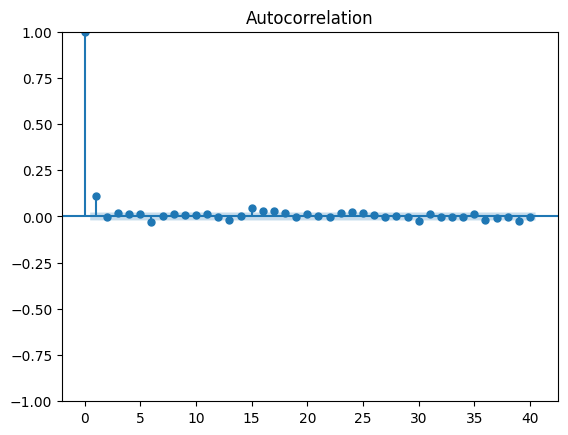

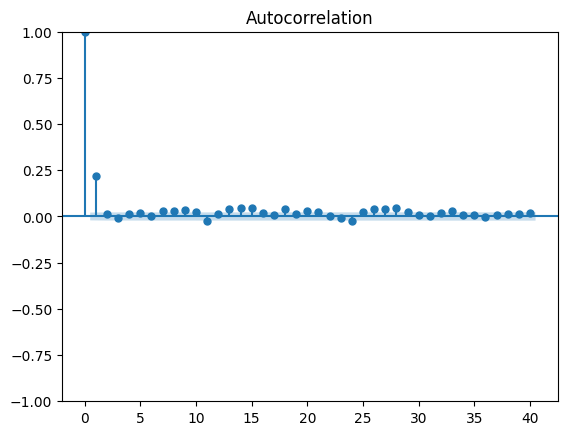

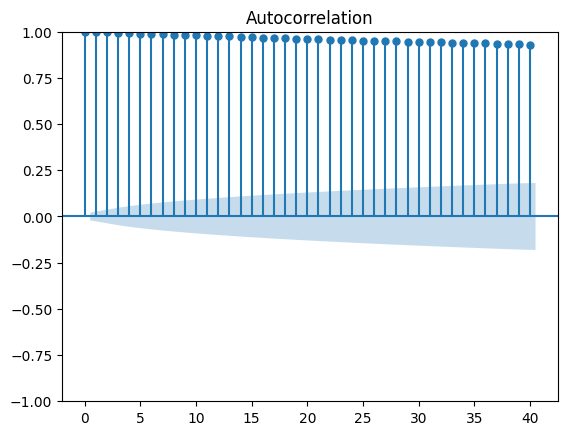

In [12]:
for f in df_factors.columns:
    plot_acf(df_factors[f])
    plt.show()

In [13]:
params = {
    'SDate':'1999-12-31',
    'EDate': '2021-06-04',
    'Curn':'Native',
}

In [14]:
    

data_dict = {}
for ric in indices_rics:
    data_dict[ric] = ek.get_data(ric, ['TR.PriceClose', 'TR.PriceClose.calcdate', 'TR.PriceClose.date'] , parameters=params)[0]
    data_dict[ric].loc[:, 'Calc Date'] = data_dict[ric].loc[:, 'Calc Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    data_dict[ric].loc[:, 'Month'] = data_dict[ric].loc[:, 'Calc Date'].apply(lambda x: x.month)
    data_dict[ric].loc[:, 'Year'] = data_dict[ric].loc[:, 'Calc Date'].apply(lambda x: x.year)
    data_dict[ric].loc[:, 'DailyLogReturns'] = np.log(data_dict[ric]['Price Close'] / data_dict[ric]['Price Close'].shift(1))
    

In [15]:
ric = indices_rics[1]
print(ric)
df = data_dict[ric]
df = pd.merge(df, df_factors, left_on='Calc Date', right_index=True, how='left')
df.head()

ASML.AS


,Instrument,Price Close,Calc Date,Date,Month,Year,DailyLogReturns,Mkt-RF,SMB,HML,RMW,CMA,RF
0,ASML.AS,39.957765,2000-01-03,2000-01-03T00:00:00Z,1,2000,<NA>,0.0021,0.0067,-0.0077,-0.0031,-0.0079,0.0002
1,ASML.AS,38.039234,2000-01-04,2000-01-04T00:00:00Z,1,2000,-0.049205,-0.0318,0.0104,0.0146,-0.0006,0.0063,0.0002
2,ASML.AS,34.411467,2000-01-05,2000-01-05T00:00:00Z,1,2000,-0.100228,-0.0151,0.0035,0.0137,-0.0031,0.0163,0.0002
3,ASML.AS,32.004583,2000-01-06,2000-01-06T00:00:00Z,1,2000,-0.072511,-0.0102,0.0039,0.0102,-0.0016,0.0101,0.0002
4,ASML.AS,34.394026,2000-01-07,2000-01-07T00:00:00Z,1,2000,0.072004,0.0208,-0.0073,-0.0098,-0.0022,-0.0019,0.0002


In [16]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
for f in factors:
    print(f"{f}: {df.loc[:, ['DailyLogReturns', f]].iloc[0,1]}")

Mkt-RF: 0.0021
SMB: 0.0067
HML: -0.0077
RMW: -0.0031
CMA: -0.0079


In [17]:
X = df.loc[:, factors].astype(float)
X = add_constant(X)
y = df.loc[:, 'DailyLogReturns'].astype(float)

In [18]:
model = OLS(
    endog=y,
    exog=X,
    missing='drop',
    hasconst=True,
)
results = model.fit()

In [19]:
results.params

const     0.000798
Mkt-RF    0.969916
SMB      -0.504763
HML      -0.957268
RMW      -1.904525
CMA      -0.275955
dtype: float64

In [20]:
results.pvalues

const      1.117684e-02
Mkt-RF    2.250732e-113
SMB        9.434347e-10
HML        2.068324e-25
RMW        8.652685e-59
CMA        3.817957e-02
dtype: float64

<AxesSubplot:xlabel='DailyLogReturns', ylabel='Count'>

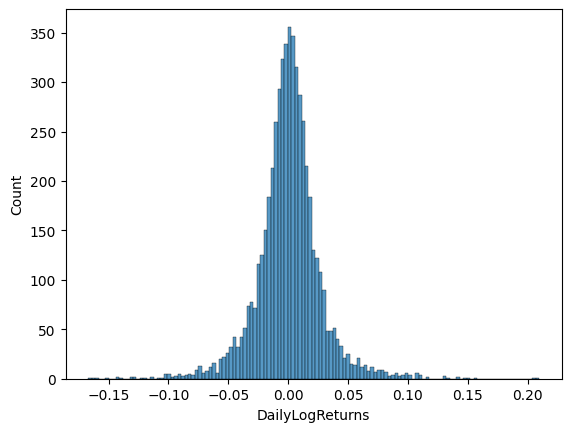

In [21]:
sns.histplot(y)

<AxesSubplot:ylabel='Count'>

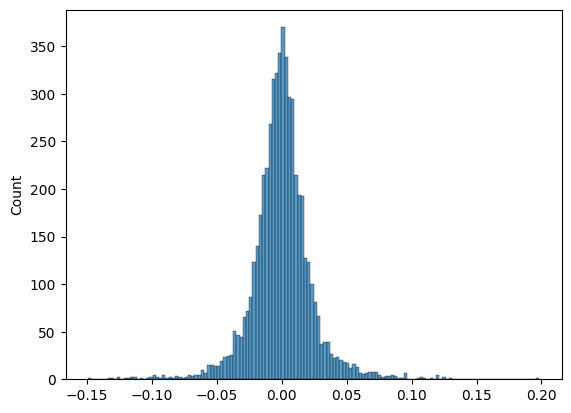

In [22]:
sns.histplot(results.resid)

In [23]:
stats.kstat(results.resid)

0.0005361461200693681

In [24]:
stats.jarque_bera(results.resid)

Jarque_beraResult(statistic=7485.989272657734, pvalue=0.0)

In [25]:
model_roll = RollingOLS(
    endog=y,
    exog=X,
    missing='drop',
    window=1500 # this is approx. 5 years
)
results_roll = model_roll.fit()

<AxesSubplot:xlabel='Calc Date'>

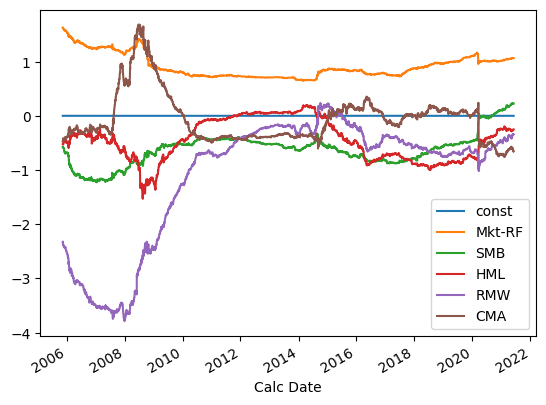

In [26]:
results_roll.params.join(df['Calc Date']).set_index('Calc Date').plot()

In [27]:
df

,Instrument,Price Close,Calc Date,Date,Month,Year,DailyLogReturns,Mkt-RF,SMB,HML,RMW,CMA,RF
0,ASML.AS,39.957765,2000-01-03,2000-01-03T00:00:00Z,1,2000,<NA>,0.0021,0.0067,-0.0077,-0.0031,-0.0079,0.0002
1,ASML.AS,38.039234,2000-01-04,2000-01-04T00:00:00Z,1,2000,-0.049205,-0.0318,0.0104,0.0146,-0.0006,0.0063,0.0002
2,ASML.AS,34.411467,2000-01-05,2000-01-05T00:00:00Z,1,2000,-0.100228,-0.0151,0.0035,0.0137,-0.0031,0.0163,0.0002
3,ASML.AS,32.004583,2000-01-06,2000-01-06T00:00:00Z,1,2000,-0.072511,-0.0102,0.0039,0.0102,-0.0016,0.0101,0.0002
4,ASML.AS,34.394026,2000-01-07,2000-01-07T00:00:00Z,1,2000,0.072004,0.0208,-0.0073,-0.0098,-0.0022,-0.0019,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,ASML.AS,547.2,2021-05-31,2021-05-31T00:00:00Z,5,2021,-0.009277,-0.0012,0.0022,-0.0020,0.0012,-0.0005,0.0000
5476,ASML.AS,551.1,2021-06-01,2021-06-01T00:00:00Z,6,2021,0.007102,0.0024,0.0055,0.0109,-0.0024,0.0040,0.0000
5477,ASML.AS,555.1,2021-06-02,2021-06-02T00:00:00Z,6,2021,0.007232,0.0016,-0.0013,0.0036,0.0001,0.0032,0.0000
5478,ASML.AS,549.4,2021-06-03,2021-06-03T00:00:00Z,6,2021,-0.010322,-0.0050,-0.0010,0.0045,0.0014,0.0027,0.0000
